# 16_SIMBA_region_entity.ipynb

1. Zuo, C., Xia, J. & Chen, L. Dissecting tumor microenvironment from spatially resolved transcriptomics data by heterogeneous graph learning. Nat Commun 15, 5057 (2024).
- They included regions as an entity in their heterogeneous graph

In [1]:
%load_ext autoreload
%autoreload 2


import sys
sys.path.insert(1, '../scripts/benchmarking')

In [22]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from src.plot import plot_spatial, palette_celltype, plot_obs_spatial
import pandas as pd
import numpy as np
palette_entity_anno = palette_celltype.copy()
palette_entity_anno['gene'] = "lightgray"
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import simba as si
import anndata as ad
from scipy.sparse import csr_matrix
# from manually added path
from spatial import gen_spatial_graph
from plot import plot_spatial_kernel
import squidpy as sq
from src.plot import plot_obs_spatial

si.settings.set_figure_params(
    dpi=80,
    style='white',
    fig_size=[5,5],
    rc={'image.cmap': 'viridis'}
)

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

workdir = 'data/16'
si.settings.set_workdir(workdir)

Saving results in: data/16


# Setup data

In [3]:
adata_fn = "/data/pinello/PROJECTS/2025-01-31_CC_Spatial_SIMBA/SIMBA_in_space/data/human_DLPFC/151507.h5ad"
adata = sc.read_h5ad(adata_fn)

In [56]:
max_x = np.max(adata.obsm['spatial'][:, 0])
max_y = np.max(adata.obsm['spatial'][:, 1])

min_x = np.min(adata.obsm['spatial'][:, 0])
min_y = np.min(adata.obsm['spatial'][:, 1])
print(min_x, max_x, min_y, max_y)

2160 10917 2513 11751


In [57]:
step_size = 500
x_grid = np.arange(max(0, min_x - step_size), max_x + step_size, step=500)
y_grid = np.arange(max(0, min_y - step_size), max_y + step_size, step=500)

In [58]:
adata.uns['spatial']['151507']['images'].keys()

dict_keys(['hires', 'lowres'])

In [59]:
adata.uns['spatial']['151507']['scalefactors']

{'fiducial_diameter_fullres': 144.56266776645353,
 'spot_diameter_fullres': 96.37511184430237,
 'tissue_hires_scalef': 0.150015,
 'tissue_lowres_scalef': 0.045004502}

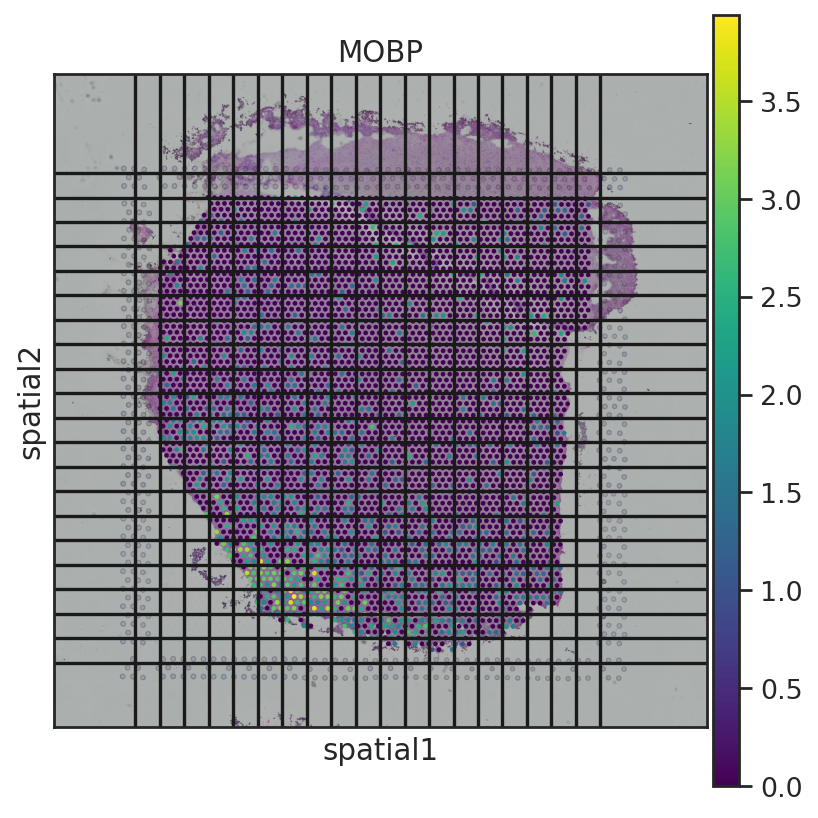

In [61]:
ax = sq.pl.spatial_scatter(adata, color='MOBP', library_id=None, size=1, linewidth=0, return_ax=True)
for x in x_grid:
    ax.axvline(x * adata.uns['spatial']['151507']['scalefactors']['tissue_hires_scalef'], c='k') 

for y in y_grid:
    ax.axhline(y * adata.uns['spatial']['151507']['scalefactors']['tissue_hires_scalef'], c='k') 

In [148]:
for i in range(len(x_grid) - 1):
    col_fil = (adata.obsm['spatial'][:, 0] >= x_grid[i]) & (adata.obsm['spatial'][:, 0] < x_grid[i + 1])
    adata.obs.loc[col_fil, 'x_region'] = i
    adata.obs.loc[col_fil, 'x_region_val'] = x_grid[i]
    
for j in range(len(y_grid) - 1):
    row_fil = (adata.obsm['spatial'][:, 1] >= y_grid[j]) & (adata.obsm['spatial'][:, 1] < y_grid[j + 1])
    adata.obs.loc[row_fil, 'y_region'] = j
    adata.obs.loc[row_fil, 'y_region_val'] = y_grid[j]

adata.obs['region_id'] = adata.obs['x_region'].astype(int).astype(str) + "_" + adata.obs['y_region'].astype(int).astype(str)
adata.obs['region_val_id'] = adata.obs['x_region_val'].astype(int).astype(str) + "_" + adata.obs['y_region_val'].astype(int).astype(str)
        

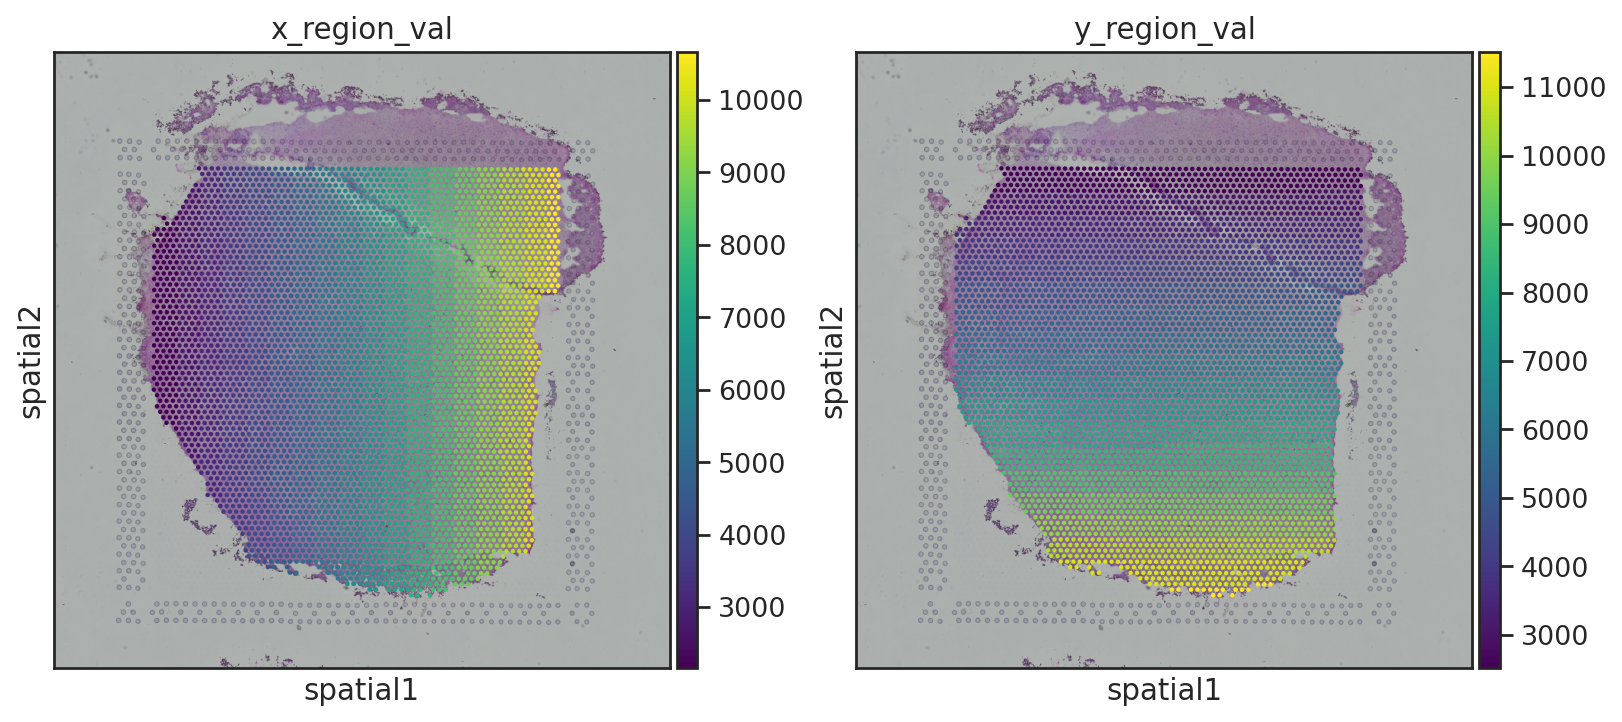

In [149]:
sq.pl.spatial_scatter(adata, color=['x_region_val', 'y_region_val'], size=1, linewidth=0)

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


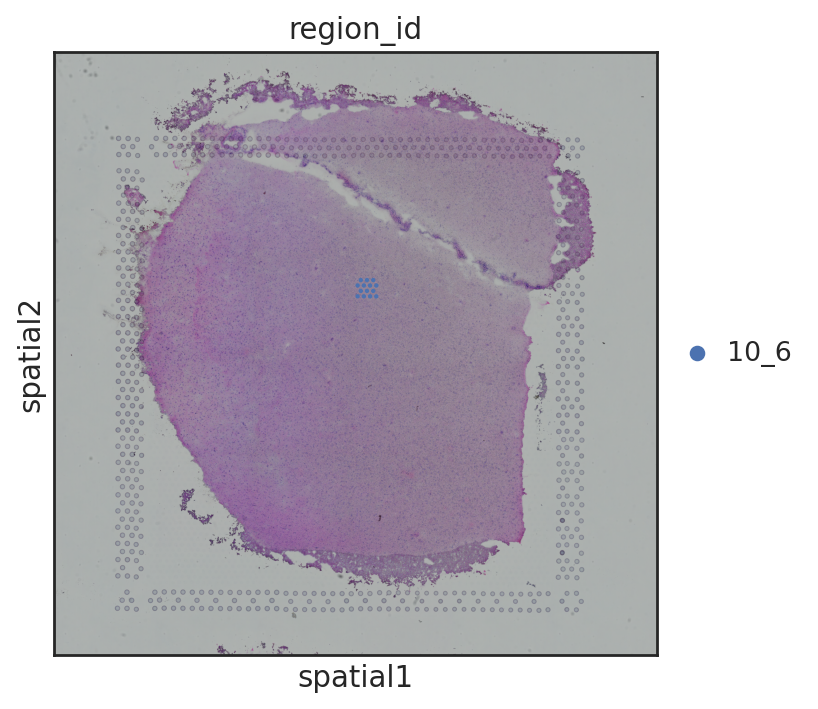

In [161]:
sq.pl.spatial_scatter(adata[adata.obs['region_id'] == '10_6'], color=['region_id'], size=1, linewidth=0)

In [135]:
cell_region_obs_df = adata.obs[['x_region', 'y_region', 'region_id']].reset_index().rename(columns={'index': 'barcode'}).sort_values(by=['x_region', 'y_region'])
cell_region_obs_df['value'] = 1 # 1 if the cell is in the region
cell_region_X = cell_region_obs_df.pivot(index='barcode', columns='region_id', values='value').fillna(0)

In [136]:
cell_region_X.sum(axis=1).unique()

array([1.])

In [169]:
cell_region_var_df = cell_region_X.sum().to_frame().rename(columns={0: "num_barcodes"})
cell_region_var_df.head()

,num_barcodes
region_id,
10_1,18.0
10_10,14.0
10_11,14.0
10_12,14.0
10_13,18.0


<Axes: >

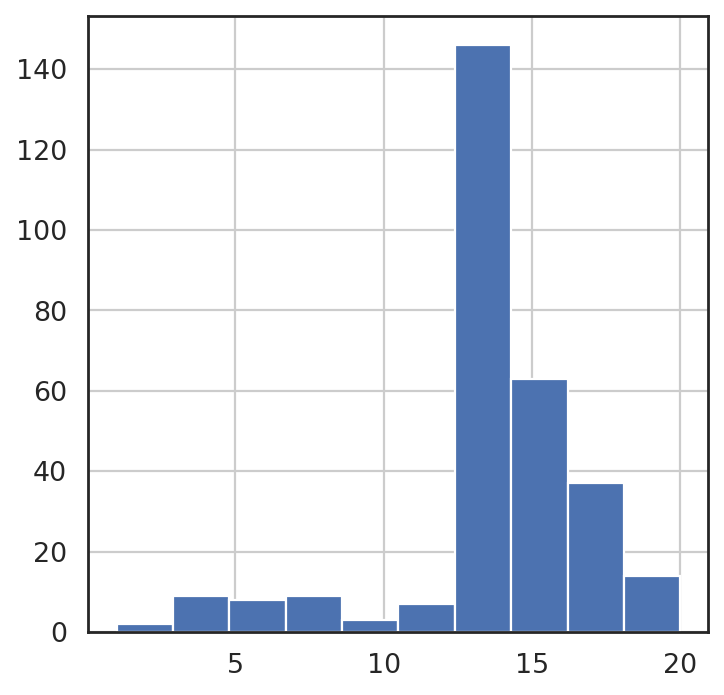

In [170]:
cell_region_var_df['num_barcodes'].hist()

In [177]:
adata_CR = ad.AnnData(csr_matrix(cell_region_X.to_numpy()), obs=adata.obs, var=cell_region_var_df)
adata_CR.layers['simba'] = adata_CR.X.copy()

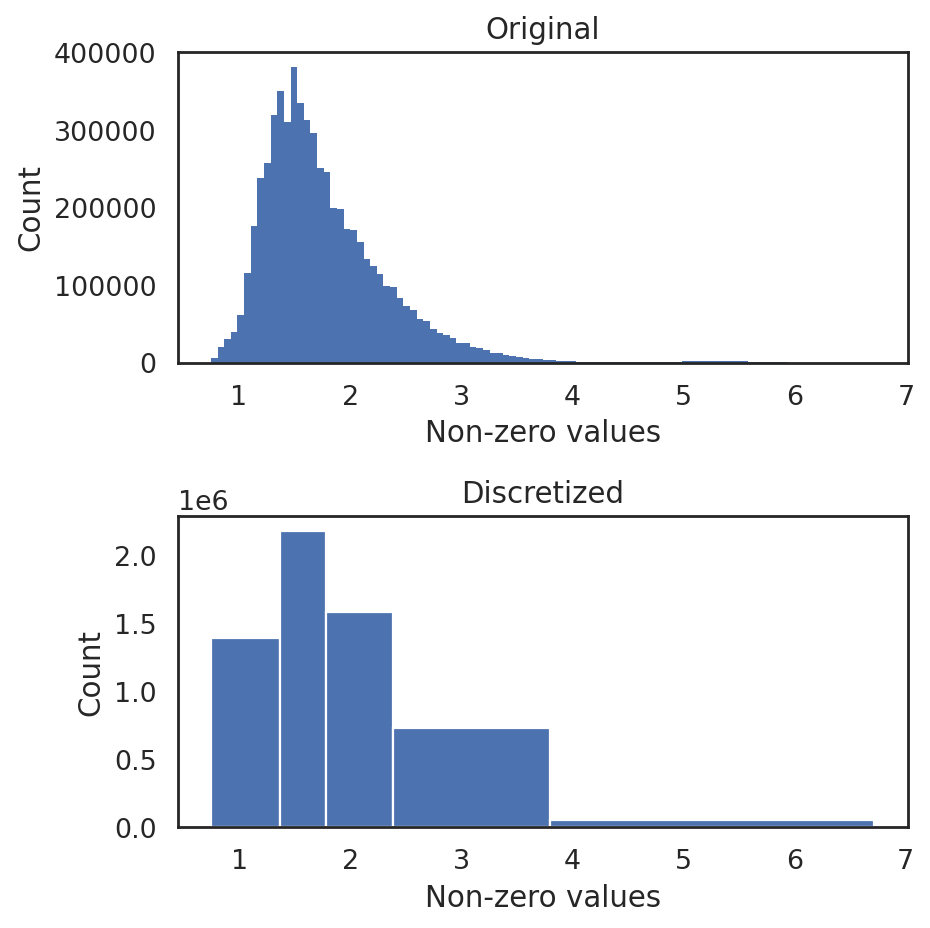

In [178]:
si.tl.discretize(adata,n_bins=5)
si.pl.discretize(adata,kde=False)

In [185]:
adata.var.index.name = 'gene'
adata.obs.index.name = 'barcode'

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 3]])

In [199]:
si.tl.gen_graph(
    list_adata=[adata, adata_CR],
    add_edge_weights=True,
    layer='simba',
    use_highly_variable=False, 
    dirname='graph_global'
)

relation0: source: E0, destination: E1
#edges: 5932209
relation1: source: E0, destination: E2
#edges: 4221
Total number of edges: 5936430
Writing graph file "pbg_graph.txt" to "data/16/pbg/graph_global" ...
Finished.


Confused why there are not separate relation types, but the weights are present in the pbg_graph.txt file

- E0 - cells
- E1 - genes
- E2 - regions

In [213]:
si.settings.pbg_params['relations']

[{'name': 'r0', 'lhs': 'E0', 'rhs': 'E1', 'operator': 'none', 'weight': 1.0},
 {'name': 'r1', 'lhs': 'E0', 'rhs': 'E2', 'operator': 'none', 'weight': 1.0}]

In [200]:
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model_CG_CR')

Auto-estimating weight decay ...
`.settings.pbg_params['wd']` has been updated to 0.005969
Weight decay being used for training is 0.005969
Converting input data ...
[2025-03-06 02:53:23.779314] Using the 2 relation types given in the config
[2025-03-06 02:53:23.779866] Searching for the entities in the edge files...
[2025-03-06 02:53:30.763234] Entity type E0:
[2025-03-06 02:53:30.766601] - Found 4221 entities
[2025-03-06 02:53:30.766994] - Removing the ones with fewer than 1 occurrences...
[2025-03-06 02:53:30.767958] - Left with 4221 entities
[2025-03-06 02:53:30.768318] - Shuffling them...
[2025-03-06 02:53:30.770592] Entity type E1:
[2025-03-06 02:53:30.770894] - Found 15818 entities
[2025-03-06 02:53:30.771204] - Removing the ones with fewer than 1 occurrences...
[2025-03-06 02:53:30.773902] - Left with 15818 entities
[2025-03-06 02:53:30.774214] - Shuffling them...
[2025-03-06 02:53:30.782055] Entity type E2:
[2025-03-06 02:53:30.782366] - Found 298 entities
[2025-03-06 02:53:30

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:


[2025-03-06 02:54:04.842318] - Processed 5936430 edges in total
Starting training ...


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/c

Finished


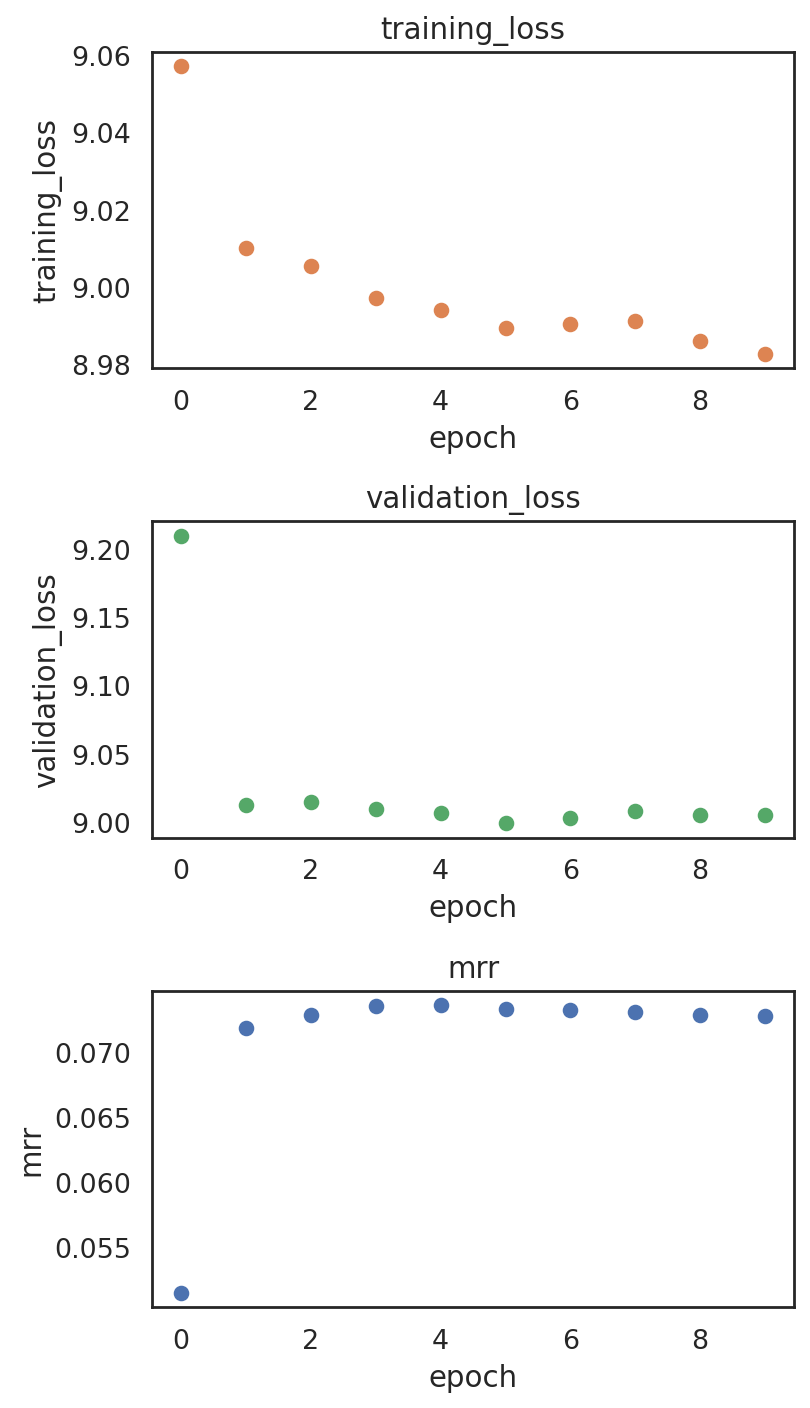

In [201]:
si.pl.pbg_metrics(fig_ncol=1)

In [202]:
# read in entity embeddings obtained from pbg training.
local_dict_adata = si.read_embedding()
local_dict_adata

{'E2': AnnData object with n_obs × n_vars = 298 × 50,
 'E1': AnnData object with n_obs × n_vars = 15818 × 50,
 'E0': AnnData object with n_obs × n_vars = 4221 × 50}

In [204]:
adata_C = local_dict_adata['E0']  # embeddings of cells
adata_G = local_dict_adata['E1']  # embeddings of cells
adata_C.obs['spatialLIBD'] = adata[adata_C.obs_names,:].obs['spatialLIBD'].copy()
# nonly_adata_C.obs['n_counts'] = adata[nonly_adata_C.obs_names,:].obs['n_counts'].copy()
# nonly_adata_C.obs['n_genes'] = adata[nonly_adata_C.obs_names,:].obs['n_genes'].copy()
adata_C

AnnData object with n_obs × n_vars = 4221 × 50
    obs: 'spatialLIBD'

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


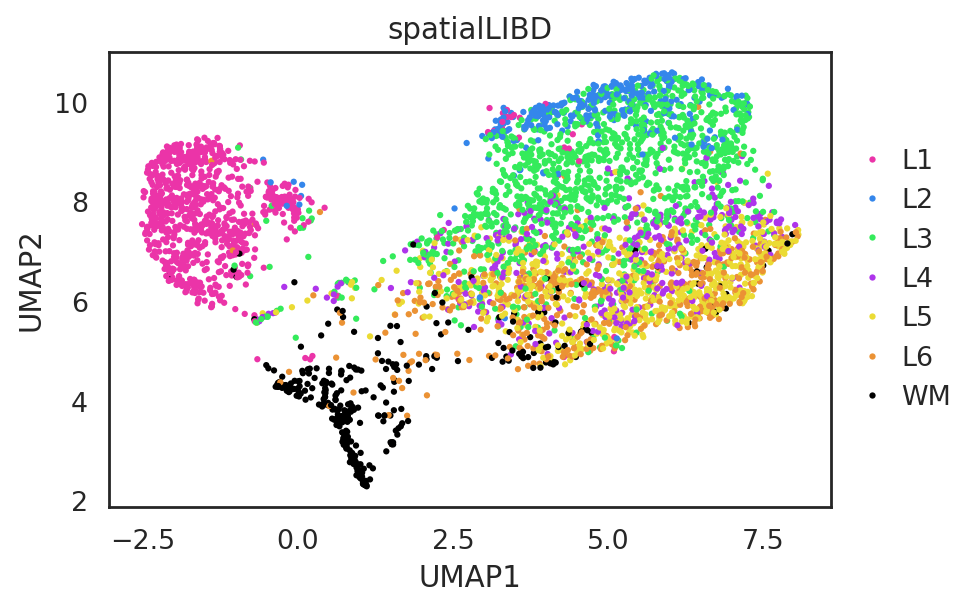

In [207]:
si.tl.umap(adata_C,n_neighbors=15,n_components=2)
si.pl.umap(
    adata_C,color=['spatialLIBD'],
    dict_palette={'spatialLIBD': palette_celltype},
    fig_size=(6,4),
    drawing_order='random'
)

In [208]:
from cluster import get_pairwise_distance
from sklearn.metrics import silhouette_score

In [209]:
dists = get_pairwise_distance(adata_C.X) # on the data in X
sil = silhouette_score(X=dists, labels=adata_C.obs['spatialLIBD'])
sil

0.05295593

# change training weights

In [214]:
si.settings.pbg_params['relations']

[{'name': 'r0', 'lhs': 'E0', 'rhs': 'E1', 'operator': 'none', 'weight': 1.0},
 {'name': 'r1', 'lhs': 'E0', 'rhs': 'E2', 'operator': 'none', 'weight': 1.0}]

In [217]:
dict_config = si.settings.pbg_params.copy()
# dict_config['wd'] = 0.015521
dict_config['relations'][-1]['weight'] = 0.5 # we usually set `wd_interval` to 10 for scRNA-seq datasets for a slower but finer training
dict_config['relations']

[{'name': 'r0', 'lhs': 'E0', 'rhs': 'E1', 'operator': 'none', 'weight': 1.0},
 {'name': 'r1', 'lhs': 'E0', 'rhs': 'E2', 'operator': 'none', 'weight': 0.5}]

In [218]:
## start training
si.tl.pbg_train(pbg_params = dict_config, auto_wd=True, save_wd=True, output='model_CG_CR_0.5')

Auto-estimating weight decay ...
`.settings.pbg_params['wd']` has been updated to 0.005969
Weight decay being used for training is 0.005969
Converting input data ...
[2025-03-06 03:14:00.909364] Found some files that indicate that the input data has already been preprocessed, not doing it again.
[2025-03-06 03:14:00.909848] These files are in: data/16/pbg/graph_global/input/entity, data/16/pbg/graph_global/input/edge
Starting training ...


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/c

Finished


In [219]:
# read in entity embeddings obtained from pbg training.
low_weight_dict_adata = si.read_embedding()
low_weight_dict_adata

{'E2': AnnData object with n_obs × n_vars = 298 × 50,
 'E1': AnnData object with n_obs × n_vars = 15818 × 50,
 'E0': AnnData object with n_obs × n_vars = 4221 × 50}

In [220]:
low_weight_adata_C = low_weight_dict_adata['E0']  # embeddings of cells
low_weight_adata_G = low_weight_dict_adata['E1']  # embeddings of cells
low_weight_adata_C.obs['spatialLIBD'] = adata[low_weight_adata_C.obs_names,:].obs['spatialLIBD'].copy()
# nonly_adata_C.obs['n_counts'] = adata[nonly_adata_C.obs_names,:].obs['n_counts'].copy()
# nonly_adata_C.obs['n_genes'] = adata[nonly_adata_C.obs_names,:].obs['n_genes'].copy()
low_weight_adata_C

AnnData object with n_obs × n_vars = 4221 × 50
    obs: 'spatialLIBD'

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


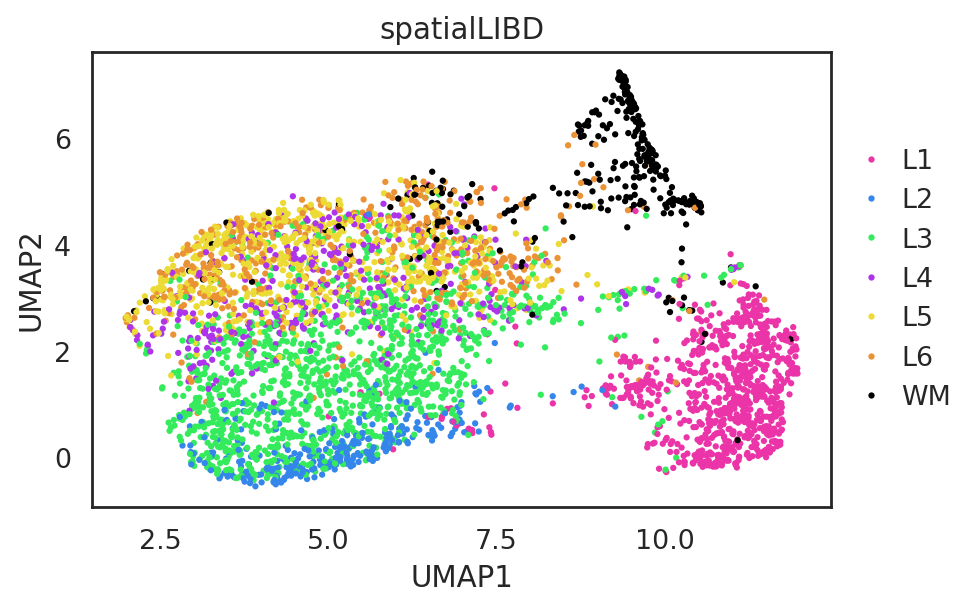

In [221]:
si.tl.umap(low_weight_adata_C,n_neighbors=15,n_components=2)
si.pl.umap(
    low_weight_adata_C,color=['spatialLIBD'],
    dict_palette={'spatialLIBD': palette_celltype},
    fig_size=(6,4),
    drawing_order='random'
)

In [222]:
dists = get_pairwise_distance(low_weight_adata_C.X) # on the data in X
sil = silhouette_score(X=dists, labels=low_weight_adata_C.obs['spatialLIBD'])
sil

0.0501055

In [223]:
workdir

'data/16'

In [224]:
adata_C.write(f"{workdir}/adata_C.h5ad")
adata_G.write(f"{workdir}/adata_G.h5ad")
low_weight_adata_C.write(f"{workdir}/low_weight_adata_C.h5ad")
low_weight_adata_G.write(f"{workdir}/low_weight_adata_G.h5ad")

In [225]:
fn = "/data/pinello/PROJECTS/2025-01-31_CC_Spatial_SIMBA/SIMBA_in_space/results/00/simba_spatial_and_rna_region_entities/151507/adata_C.h5ad"
test_adata_c = sc.read_h5ad(fn)

In [228]:
si.tl.umap(test_adata_c,n_neighbors=15,n_components=2)

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [230]:
test_adata_c

AnnData object with n_obs × n_vars = 4221 × 50
    obs: 'spatialLIBD', 'n_counts', 'n_genes'
    obsm: 'X_umap'

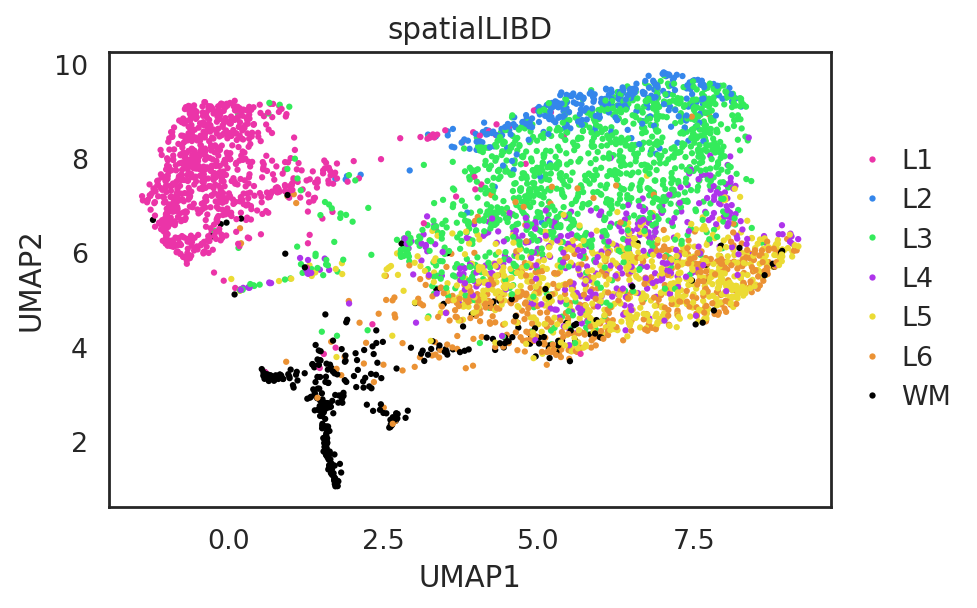

In [232]:
si.pl.umap(test_adata_c, color=['spatialLIBD'], dict_palette={'spatialLIBD': palette_celltype},
    fig_size=(6,4),
    drawing_order='random')